<a href="https://colab.research.google.com/drive/1NCmAQ8Y3UdMsObhyXNhPXO5resdnOjpK?usp=sharing" target="_blank">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/>
</a>

In [1]:
!pip install -q fastai




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 119.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 100.6 MB/s eta 0:00:00


In [2]:
from fastai.vision.all import *
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
# Load dataset
path = untar_data(URLs.PETS)

# Labeling function: capitalize = cat
def is_cat(fname): return fname.name[0].isupper()

# Print file structure
print("Dataset path:", path)
print("Files available:", (path/'images').ls()[:5])


Dataset path: /root/.fastai/data/oxford-iiit-pet
Files available: [Path('/root/.fastai/data/oxford-iiit-pet/images/Russian_Blue_125.jpg'), Path('/root/.fastai/data/oxford-iiit-pet/images/american_pit_bull_terrier_26.jpg'), Path('/root/.fastai/data/oxford-iiit-pet/images/Bombay_161.jpg'), Path('/root/.fastai/data/oxford-iiit-pet/images/Ragdoll_191.jpg'), Path('/root/.fastai/data/oxford-iiit-pet/images/american_bulldog_118.jpg')]


In [4]:
# Preview file names and labels
img_files = get_image_files(path/"images")
labels = [is_cat(f) for f in img_files]

df = pd.DataFrame({
    "filename": [f.name for f in img_files[:10]],
    "label (is_cat)": labels[:10]
})
df


,filename,label (is_cat)
0,Russian_Blue_125.jpg,True
1,american_pit_bull_terrier_26.jpg,False
2,Bombay_161.jpg,True
3,Ragdoll_191.jpg,True
4,american_bulldog_118.jpg,False
5,scottish_terrier_33.jpg,False
6,leonberger_62.jpg,False
7,miniature_pinscher_91.jpg,False
8,Birman_125.jpg,True
9,leonberger_197.jpg,False


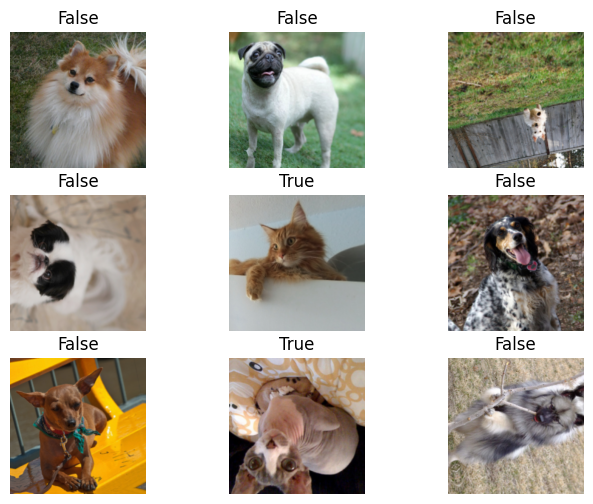

In [5]:
pets = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(seed=42),
    get_y=is_cat,
    item_tfms=Resize(224),
    batch_tfms=aug_transforms(
        flip_vert=True,
        max_rotate=20,
        max_zoom=1.1,
        max_lighting=0.2,
        max_warp=0.2
    )
)

dls = pets.dataloaders(path/"images", bs=32)
dls.show_batch(max_n=9, figsize=(8, 6))


In [6]:
# Build a ResNet18-based classifier
learn = cnn_learner(dls, resnet18, metrics=accuracy)

# Train for 5 epochs
learn.fine_tune(5)


/usr/local/lib/python3.11/dist-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 98.2MB/s]


epoch,train_loss,valid_loss,accuracy,time
0,0.293278,0.050245,0.983085,00:49


epoch,train_loss,valid_loss,accuracy,time
0,0.166271,0.020944,0.991881,00:42
1,0.113952,0.043940,0.985115,00:43
2,0.075908,0.019474,0.995264,00:41
3,0.069522,0.019314,0.993234,00:42
4,0.041372,0.016399,0.992558,00:48


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

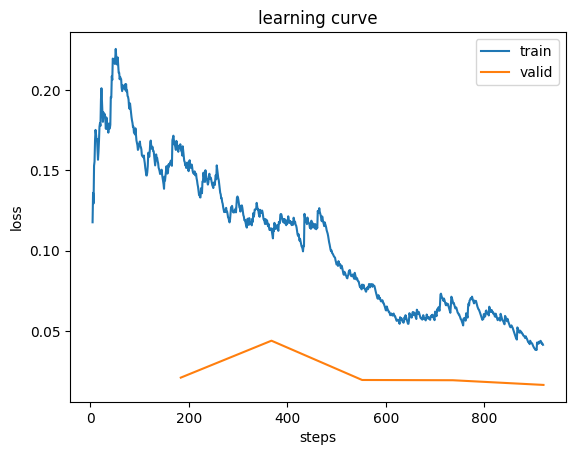

In [7]:
# Show training/validation loss & accuracy
learn.recorder.plot_loss()


In [8]:
val_loss, val_acc = learn.validate()
print(f"\nValidation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")



Validation Loss: 0.0164
Validation Accuracy: 0.9926


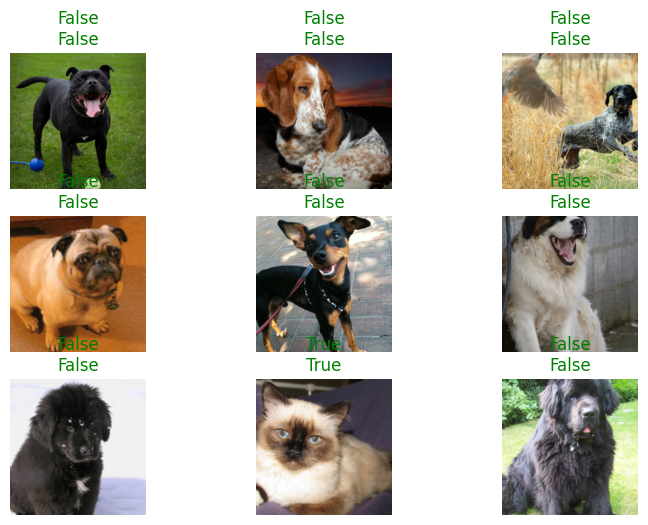

In [10]:
# Visualize predictions
learn.show_results(max_n=9, figsize=(9, 6))


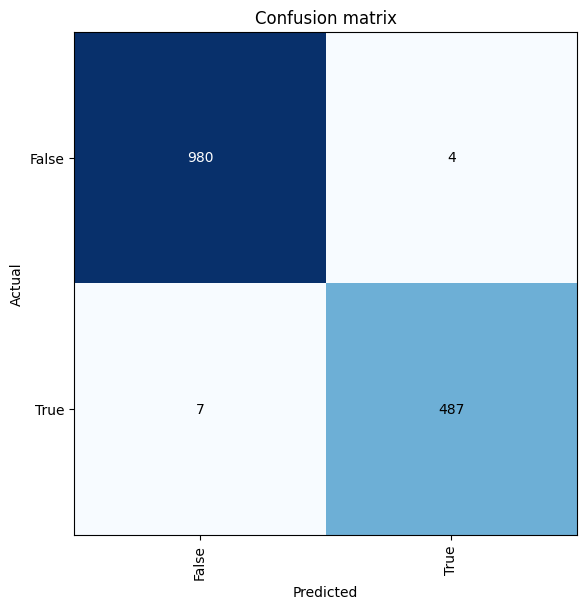

In [11]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(6,6))


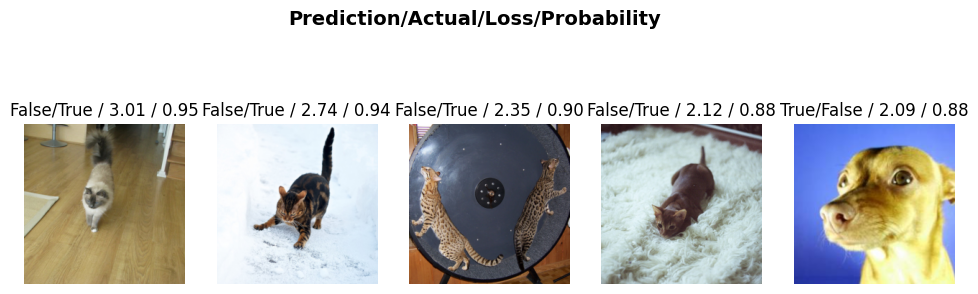

In [12]:
# Top 5 incorrectly predicted samples
interp.plot_top_losses(5, nrows=1, figsize=(12, 4))


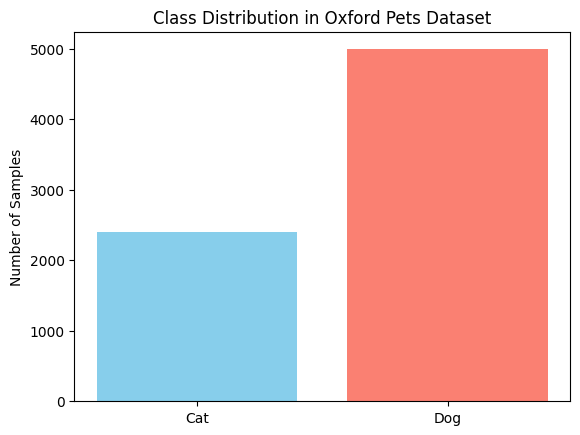

In [13]:
from collections import Counter

counts = Counter([is_cat(f) for f in img_files])
labels = ["Cat", "Dog"]
values = [counts[True], counts[False]]

plt.bar(labels, values, color=["skyblue", "salmon"])
plt.title("Class Distribution in Oxford Pets Dataset")
plt.ylabel("Number of Samples")
plt.show()
